In [1]:
import pandas as pd
import numpy as np
import os
import chardet
import glob
import json
import requests
from bs4 import BeautifulSoup
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.stats import randint

from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV


## data_train_1 folder

In [ ]:
with open('data/data_train_1/datasource1.csv', 'rb') as fname:
    datasource1 = fname.read()[:100]
    
chardet.detect(datasource1)

In [ ]:
data_train_1_1 = pd.read_csv(os.path.join('data','data_train_1','datasource1.csv'), encoding = 'windows-1251').set_index('id')
data_train_1_1.head()

In [ ]:
data_train_1_2 = pd.read_json(os.path.join('data','data_train_1','datasource2.json'), orient = 'split')

In [ ]:
data_train_1_2.head()

In [ ]:
data_train_1_3 = pd.read_csv(os.path.join('data','data_train_1','datasource3.csv'), delimiter = '|').set_index('id')

In [ ]:
data_train_1_3.head()

## data_train_2 folder

In [ ]:
data_train_2_1 = pd.read_html(os.path.join('data','data_train_2','datasource4.html'))[0]

In [ ]:
data_train_2_1.columns = data_train_2_1.columns.get_level_values(0)
data_train_2_1.columns = ['id', 'isusingmultipledevices', 'freereturn', 'userid']

In [ ]:
data_train_2_1 = data_train_2_1.set_index('id')

In [ ]:
data_train_2_1.head()

In [ ]:
data_train_2_2 = pd.read_json(os.path.join('data','data_train_2','datasource5.csv'))

In [ ]:
data_train_2_2.head()

In [ ]:
data_train_2_3 = pd.read_csv(os.path.join('data','data_train_2','datasource7.csv')).set_index('id')

In [ ]:
data_train_2_3.head()

## data_train_3 folder

In [ ]:
path = r'data/datasource6'
files = glob.glob(os.path.join(path, "*.csv"))

df_files = (pd.read_csv(f) for f in files)
data_train_3_1  = pd.concat(df_files).set_index('id')

In [ ]:
data_train_3_1.head()

In [ ]:
df_local = data_train_1_1.join(data_train_1_2).join(data_train_1_3).join(data_train_2_1).join(data_train_2_2).join(data_train_2_3).join(data_train_3_1)


In [ ]:
df_local.shape

## API

In [ ]:
api_index = data_final[data_final.category_1stlevel == 'API'].index.values.tolist()

In [ ]:
api_index[:4]

In [ ]:
url = 'https://y29rdnycjd.execute-api.eu-west-1.amazonaws.com/dev//missingdata/{id}' 

In [ ]:
api_data = []
for i in api_index:
    api_data.append(requests.get(url.format(id=i)).json())
    

In [ ]:
len(api_data)

In [ ]:
df_api = pd.DataFrame(api_data)

In [ ]:
df_api['id'] = api_index

In [ ]:
df_api = df_api.set_index('id')

In [ ]:
df_api = df_api.drop(columns = 'returned')

In [ ]:
df_api.head()

## Web Scrapping

In [ ]:
web_index = data_final[data_final.category_1stlevel == 'WEBSITE'].index.values.tolist()

In [ ]:
%%time
dfs = []
for i in range(1,401,1):

    response = requests.get('https://scrap-me.herokuapp.com/items?page={page}'.format(page=i))
    soup = BeautifulSoup(response.content, 'html.parser')
    cast_list = soup.find_all('table', class_="table table-bordered table-hover text-center")[0]
    tr = cast_list.find_all('tr')
    df = pd.DataFrame([list(tr.text.replace('\n', '|')[1:].split('|')) for tr in tr])
    new_header = df.iloc[0] 
    df = df[1:] 
    df.columns = new_header
    dfs.append(df)

In [ ]:
df_web = pd.concat(dfs)

In [ ]:
df_web = df_web.set_index('id')

## Database

In [ ]:
# Db settings - PostgreSQL
username = 'ldsa_student'
password = 'JGIYc6jD'
host_name = 'data-wrangling-batch3.cl9uj9cucww7.eu-west-1.rds.amazonaws.com'
port = 5432
db_name = 'datawrangling'
schema = 'hackathon_students'

conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)
conn_args = {'options': '-csearch_path={}'.format(schema)}

In [ ]:
db = create_engine(conn_str, connect_args=conn_args)

In [ ]:
conn = db.connect()

In [ ]:
conn.execute("""
SELECT
   *
FROM
   pg_catalog.pg_tables
WHERE
   schemaname != 'pg_catalog'
AND schemaname != 'information_schema';
""").fetchall()

In [ ]:
query = 'SELECT * FROM targets;'
targets = pd.read_sql_query(query, engine)

In [ ]:
targets = targets.set_index('id')

In [ ]:
query = 'SELECT * FROM storeid;'
store_id = pd.read_sql_query(query, engine)

In [ ]:
store_id = store_id.set_index('id')

## Joining all data

In [ ]:
df = df_local.join(store_id)

In [ ]:
df = df[-df.issale.isin(['WEBSITE', 'API'])]

In [ ]:
df1 = pd.concat([df, df_api, df_web])

In [ ]:
df = df1.join(targets).drop(columns='')

In [ ]:
df.to_csv('train_data.csv')

## Feature Engineering

In [2]:
df = pd.read_csv('train_data.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(543341, 36)

In [4]:
df = df.drop(columns ='Unnamed: 1')

In [5]:
df.columns

Index(['id', 'brand', 'category_1stlevel', 'country', 'countrycode',
       'countryoforigin', 'ddprate', 'ddpsubcategory', 'designer',
       'freereturn', 'hasitemsonbag', 'hasusedwishlist', 'isreseller',
       'issale', 'isusingmultipledevices', 'isvip', 'ldsa_team_wishes_you',
       'orderdate_gmt', 'orderportalid', 'platform', 'productid', 'promocode',
       'region', 'shipper', 'shiptypeid', 'size', 'storeid', 'style',
       'test strings (delete please)', 'tierafterorder', 'tierbeforeorder',
       'useless values (delete please)', 'userfraudstatus', 'userid',
       'returned'],
      dtype='object')

In [6]:
def prepare_dataset(df, categorical_features):
    _df= df.copy()
    
    for i in categorical_features:
        _df[i] = _df[i].str.lower().str.strip()
        
    _df = _df.drop(columns=['ldsa_team_wishes_you', 'test strings (delete please)',
                            'useless values (delete please)', 'id',
                           'countrycode', 'designer', 'orderportalid', 'userid'])
    _df['orderdate_gmt'] = pd.to_datetime(df['orderdate_gmt'])
    return _df

In [7]:
object_type = df.dtypes == 'object'

In [8]:
categorical = df.dtypes[object_type].index.tolist()

In [9]:
df = prepare_dataset(df, categorical)

In [10]:
df.columns

Index(['brand', 'category_1stlevel', 'country', 'countryoforigin', 'ddprate',
       'ddpsubcategory', 'freereturn', 'hasitemsonbag', 'hasusedwishlist',
       'isreseller', 'issale', 'isusingmultipledevices', 'isvip',
       'orderdate_gmt', 'platform', 'productid', 'promocode', 'region',
       'shipper', 'shiptypeid', 'size', 'storeid', 'style', 'tierafterorder',
       'tierbeforeorder', 'userfraudstatus', 'returned'],
      dtype='object')

In [11]:
df.head(10)

,brand,category_1stlevel,country,countryoforigin,ddprate,ddpsubcategory,freereturn,hasitemsonbag,hasusedwishlist,isreseller,...,region,shipper,shiptypeid,size,storeid,style,tierafterorder,tierbeforeorder,userfraudstatus,returned
0,1,accessories,1,1,0.0000,articles of a kind normally carried in the poc...,1,no,yes,no,...,1,1,1,1,1,1,t4,NaN,1,0
1,2,clothing,1,2,5.0083,NaN,1,no,yes,no,...,1,2,2,2,2,2,t3,t3,2,0
2,3,clothing,2,2,42.2351,"jerseys, pullovers, cardigans, waistcoats and ...",1,yes,no,no,...,1,2,2,3,3,3,t3,NaN,1,0
3,4,shoes,2,2,42.2351,footwear with outer soles of rubber or plastics,1,yes,no,no,...,1,2,2,4,4,4,t3,NaN,1,0
4,5,shoes,1,1,5.0083,footwear with outer soles of rubber or plastics,1,no,no,no,...,1,2,2,5,5,5,t4,NaN,3,0
5,6,accessories,3,1,0.0000,"ties, bow ties and cravats",1,no,no,no,...,2,2,2,6,6,6,t2,t2,3,0
6,7,accessories,3,1,0.0000,"ties, bow ties and cravats",1,no,no,no,...,2,2,2,6,7,7,t2,t2,3,0
7,8,accessories,3,1,0.0000,"ties, bow ties and cravats",1,no,no,no,...,2,3,2,6,8,8,t2,t2,3,0
8,9,clothing,3,3,0.0000,"trousers, overalls, shorts",1,yes,no,no,...,2,2,2,7,9,9,t4,t4,3,0
9,14,clothing,3,1,0.0000,"trousers, overalls, shorts",1,yes,no,no,...,2,2,2,7,267,15489,t4,t4,3,1


In [12]:
df.describe(exclude=np.number).T

,count,unique,top,freq,first,last
category_1stlevel,542687,33,clothing,278172,NaT,NaT
ddpsubcategory,497997,126,"jerseys, pullovers, cardigans, waistcoats and ...",59037,NaT,NaT
hasitemsonbag,542584,2,no,298293,NaT,NaT
hasusedwishlist,542584,2,yes,393562,NaT,NaT
isreseller,542584,2,no,507561,NaT,NaT
issale,543341,2,yes,295262,NaT,NaT
isusingmultipledevices,542584,2,no,336439,NaT,NaT
isvip,542584,4,not vip,424596,NaT,NaT
orderdate_gmt,543341,347163,2018-01-10 15:28:51.970000+00:00,94,2018-01-01 00:00:19.733000+00:00,2018-02-18 23:59:12.003000+00:00
platform,446864,2,web,315468,NaT,NaT


In [13]:
df.isna().sum()

brand                          0
category_1stlevel            654
country                        0
countryoforigin                0
ddprate                        0
ddpsubcategory             45344
freereturn                     0
hasitemsonbag                757
hasusedwishlist              757
isreseller                   757
issale                         0
isusingmultipledevices       757
isvip                        757
orderdate_gmt                  0
platform                   96477
productid                      0
promocode                      0
region                         0
shipper                        0
shiptypeid                     0
size                           0
storeid                        0
style                          0
tierafterorder             38152
tierbeforeorder           190131
userfraudstatus                0
returned                       0
dtype: int64

In [14]:
df.platform.value_counts()

web    315468
app    131396
Name: platform, dtype: int64

In [15]:
df.tierafterorder.value_counts()

t4     231316
t2      83600
t3      77007
vip     71400
t1      41866
Name: tierafterorder, dtype: int64

In [16]:
df.tierbeforeorder.value_counts()

t4     126988
t2      67268
vip     67200
t3      56114
t1      35640
Name: tierbeforeorder, dtype: int64

In [17]:
df.category_1stlevel.value_counts()

clothing                 278172
shoes                    137002
accessories               40485
bags                      36206
girls clothing            10189
boys clothing             10119
jewellery                  6767
homeware                   4659
baby boy clothing          3754
baby girl clothing         3448
activewear                 1971
girls shoes                1788
teen boy clothing          1741
boys shoes                 1524
teen girl clothing         1339
pre-owned                   958
girls accessories           614
boys accessories            464
fine jewellery              278
baby boy accessories        276
baby girl accessories       273
watches                     154
teen girl shoes             123
baby girl shoes             118
baby boy shoes               97
teen boy shoes               95
n/d                          29
grooming                     17
teen girl accessories        13
teen boy accessories          9
demi-fine jewellery           2
baby boy

In [18]:
df.platform.value_counts()

web    315468
app    131396
Name: platform, dtype: int64

In [19]:
def cleaning_na(df):
    
    _df = df.copy()
    
    _df = _df.drop(df[df['hasitemsonbag'].isna() == True].index)
    
    _df['platform'] = _df['platform'].fillna(_df['platform'].mode()[0])
    _df['category_1stlevel'] = _df['category_1stlevel'].fillna(_df['category_1stlevel'].mode()[0])
    _df['tierbeforeorder'] = _df['tierbeforeorder'].fillna(_df['tierbeforeorder'].mode()[0])
    _df['tierafterorder'] = _df['tierafterorder'].fillna(_df['tierafterorder'].mode()[0])
    _df['ddpsubcategory'] = _df['ddpsubcategory'].fillna('n/d')
    _df['isvip'] = _df['isvip'].replace({'vip@feb14': 'vip'})

    
    return _df

    

In [20]:
def date_time(df):
    
    _df = df.copy()
    
    
    _df = _df.assign(HourDay =_df['orderdate_gmt'].dt.hour
                + (_df['orderdate_gmt'].dt.minute / 60),
            DayWeek =_df['orderdate_gmt'].dt.dayofweek,
              Month = _df['orderdate_gmt'].dt.month)
    
    _df = _df.drop(columns ='orderdate_gmt')

    return _df
    

In [21]:
df = cleaning_na(df)

In [22]:
df = date_time(df)

In [23]:
df.corr()[df.corr() > abs(0.7)]

,brand,country,countryoforigin,ddprate,freereturn,productid,promocode,region,shipper,shiptypeid,size,storeid,style,userfraudstatus,returned,HourDay,DayWeek,Month
brand,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countryoforigin,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ddprate,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freereturn,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productid,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.867171,NaN,NaN,NaN,NaN,NaN
promocode,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shiptypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df = df.drop(columns='productid') #productid and style are highly correlated, then dropping one of them

In [25]:
df.describe(exclude=np.number).T

,count,unique,top,freq
category_1stlevel,542584,33,clothing,278434
ddpsubcategory,542584,126,n/d,73358
hasitemsonbag,542584,2,no,298293
hasusedwishlist,542584,2,yes,393562
isreseller,542584,2,no,507561
issale,542584,2,yes,294815
isusingmultipledevices,542584,2,no,336439
isvip,542584,3,not vip,424596
platform,542584,2,web,411188
tierafterorder,542584,5,t4,268900


In [26]:
X = df.drop(columns='returned')

In [27]:
X.columns

Index(['brand', 'category_1stlevel', 'country', 'countryoforigin', 'ddprate',
       'ddpsubcategory', 'freereturn', 'hasitemsonbag', 'hasusedwishlist',
       'isreseller', 'issale', 'isusingmultipledevices', 'isvip', 'platform',
       'promocode', 'region', 'shipper', 'shiptypeid', 'size', 'storeid',
       'style', 'tierafterorder', 'tierbeforeorder', 'userfraudstatus',
       'HourDay', 'DayWeek', 'Month'],
      dtype='object')

In [28]:
## some features dropped after analysing features importance

X = X[['style',
 'HourDay',
 'storeid',
 'brand',
 'size',
 'DayWeek',
 'country',
 'ddpsubcategory',
 'countryoforigin',
 'promocode']]

In [29]:
y = df[['returned']]

## Encoding Categorical Features with Binary Encoder

In [30]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=1)

In [31]:
def encoding_features(X_train__, y_train__,  X_test__):
    te = TargetEncoder()
    te.fit(X_train__, y_train__)
    X_train_enc = te.transform(X_train__)
    X_test_enc = te.transform(X_test__)
    

    minmax= MinMaxScaler()
    minmax.fit(X_train_enc)
    X_train_minmax = minmax.transform(X_train_enc)
    X_test_minmax = minmax.transform(X_test_enc)
    
    return X_train_minmax, X_test_minmax

In [32]:
X_train, X_test = encoding_features(X_train_, y_train_,X_test_)

In [33]:
rf = RandomForestClassifier()

In [36]:
rf.fit(X_train, y_train_)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
y_pred = rf.predict(X_test)

In [39]:
print('Accuracy:', round(accuracy_score(y_test_, y_pred), 3))
print('Precision:', round(precision_score(y_test_, y_pred), 3))
print('Recall:', round(recall_score(y_test_, y_pred), 3))
print('AUROC Score:', round(roc_auc_score(y_test_, y_pred), 3))

Accuracy: 0.914
Precision: 0.938
Recall: 0.199
AUROC Score: 0.599


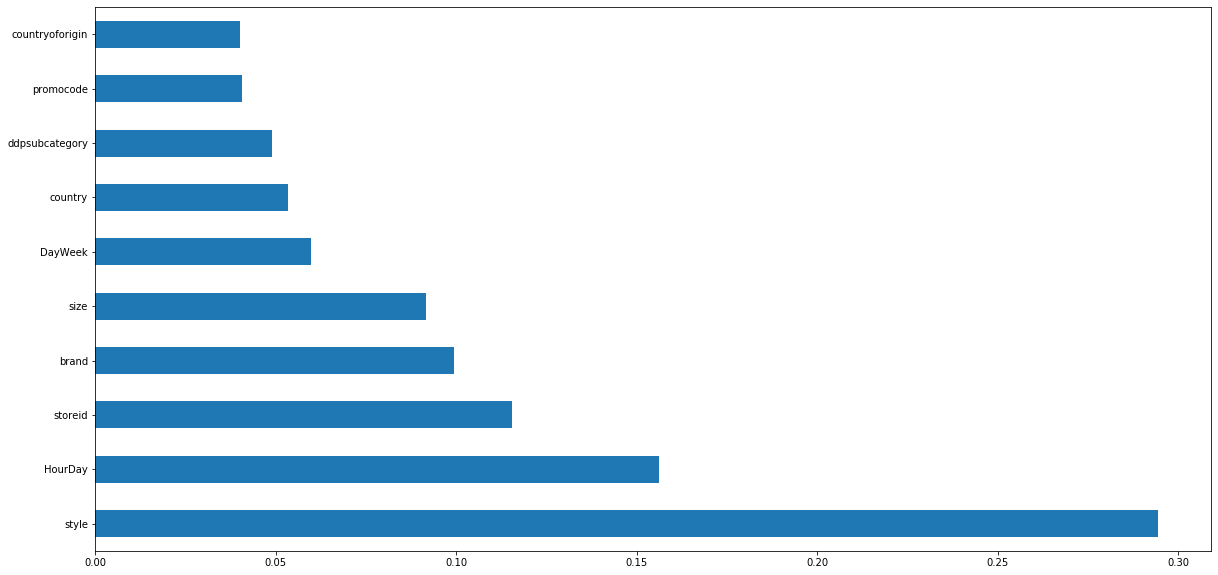

In [40]:
plt.figure(figsize=(20,10))
pd.Series(abs(rf.feature_importances_), index=X.columns).nlargest(10).plot.barh();

In [46]:
parameter_space = {'max_depth': [10, 50, 100, 200],
                   'n_estimators': [10, 50, 100, 200]}

In [47]:
rf_randomsearch = RandomizedSearchCV(estimator = RandomForestClassifier(),
                                     param_distributions= parameter_space,
                                     n_iter= 5,
                                     cv=3,
                                     scoring='roc_auc')

In [48]:
rf_randomsearch.fit(X_train, y_train_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y wa

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [49]:
y_pred_random = rf_randomsearch.predict(X_test)

In [50]:
print('Accuracy:', round(accuracy_score(y_test_, y_pred_random), 3))
print('Precision:', round(precision_score(y_test_, y_pred_random), 3))
print('Recall:', round(recall_score(y_test_, y_pred_random), 3))
print('AUROC Score:', round(roc_auc_score(y_test_, y_pred_random), 3))

Accuracy: 0.914
Precision: 0.938
Recall: 0.2
AUROC Score: 0.599


In [51]:
rf_randomsearch.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)